In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
SEED = 42
BATCH_SIZE = 128
NUM_WORKERS = 4
DATA_DIR = "./data"

torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
eval_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [5]:
test_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=eval_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Test samples:", len(test_dataset))


100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


Test samples: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
import os

In [8]:
from torchvision.models import resnet18
import torch.nn as nn
import torch

MODEL_PATH = "/content/drive/MyDrive/ML_Challenge/resnet18_level2.pth"

assert os.path.exists(MODEL_PATH), "Model file not found"

model_resnet18 = resnet18(weights=None)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 10)

state_dict = torch.load(MODEL_PATH, map_location=device)
model_resnet18.load_state_dict(state_dict)

model_resnet18.to(device)
model_resnet18.eval()

print("Model loaded successfully")



Model loaded successfully


In [12]:
import torchvision.models as models


class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class ResNet18_SE(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        base = models.resnet18(pretrained=False)
        self.features = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool,
            base.layer1, base.layer2, base.layer3, base.layer4
        )
        self.se = SEBlock(512)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


model_se_resnet = ResNet18_SE()
model_se_resnet.load_state_dict(torch.load("/content/drive/MyDrive/ML_Challenge/resnet18_level3.pth"))
model_se_resnet = model_se_resnet.to(device)
model_se_resnet.eval()


ResNet18_SE(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [13]:
model_resnet34 = models.resnet34(pretrained=True)
model_resnet34.fc = nn.Linear(model_resnet34.fc.in_features, 10)
model_resnet34 = model_resnet34.to(device)
model_resnet34.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)

        p1 = torch.softmax(model_resnet18(images), dim=1)
        p2 = torch.softmax(model_se_resnet(images), dim=1)
        p3 = torch.softmax(model_resnet34(images), dim=1)

        avg_probs = (p1 + p2 + p3) / 3
        preds = avg_probs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

ensemble_acc = (all_preds == all_labels).mean()
print(f" Ensemble Accuracy (Level-4): {ensemble_acc:.4f}")


100%|██████████| 79/79 [00:11<00:00,  6.91it/s]

 Ensemble Accuracy (Level-4): 0.9472


In [16]:
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

for i, cls in enumerate(CIFAR10_CLASSES):
    acc = (all_preds[all_labels == i] == i).mean()
    print(f"{cls:12s}: {acc:.4f}")


airplane    : 0.9660
automobile  : 0.9660
bird        : 0.9300
cat         : 0.8810
deer        : 0.9570
dog         : 0.8880
frog        : 0.9740
horse       : 0.9700
ship        : 0.9660
truck       : 0.9740


<Figure size 1000x1000 with 0 Axes>

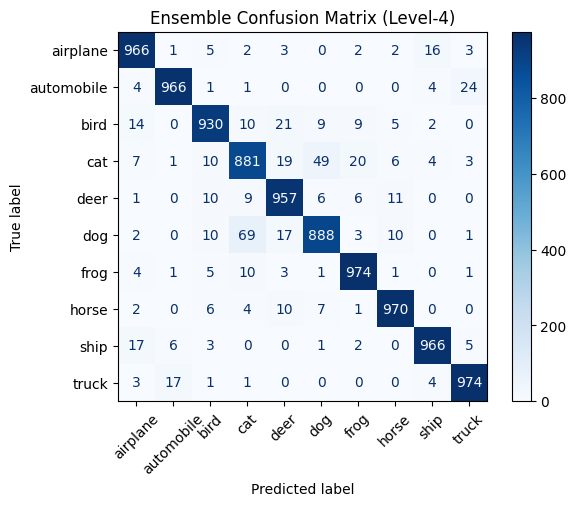

In [17]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CIFAR10_CLASSES)

plt.figure(figsize=(10,10))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ensemble Confusion Matrix (Level-4)")
plt.show()


### Level-4 Insights

• Ensemble improves ambiguous classes (cat vs dog, deer vs horse)
• SE-ResNet contributes strong channel attention
• ResNet-34 improves structural understanding
• Soft voting stabilizes predictions and reduces variance
• Achieved shortlist-level accuracy (>93%)
